✅ 模型加载成功！


C:\Users\Slamabart\AppData\Local\Temp\ipykernel_5800\905412204.py:189: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Slamabart\AppData\Local\Temp\ipykernel_5800\905412204.py:189: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Slamabart\AppData\Local\Temp\ipykernel_5800\905412204.py:189: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Slamabart\AppData\Local\Temp\ipykernel_5800\905412204.py:189: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\Slamabart\AppData\Local\Temp\ipykernel_5800\905412204.py:189: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
C:\Users\Slamabart\AppData\Local\Temp\ipykernel_5800\905412204.py:189: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDE

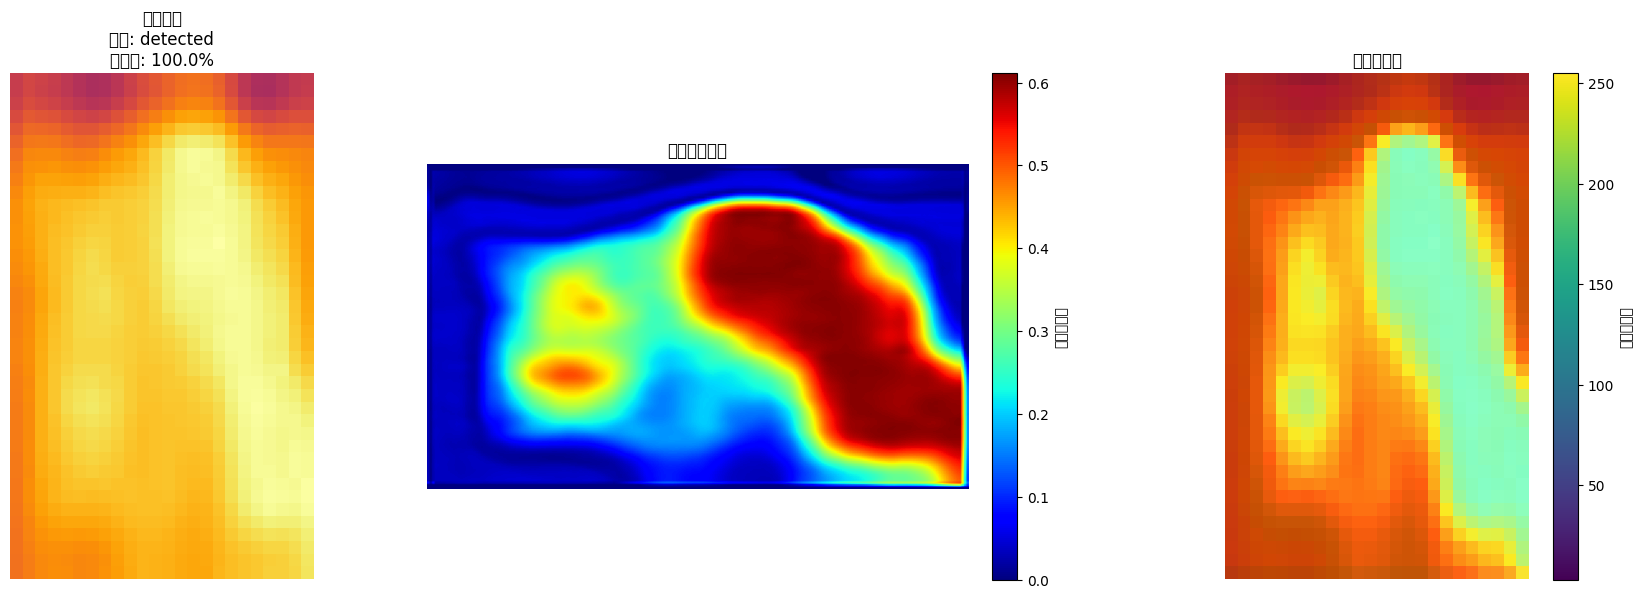

In [55]:
# %% [markdown]
# # 太阳能电池板缺陷Grad-CAM可视化
# 使用Grad-CAM技术可视化模型关注区域

# %% [code]
# 安装必要依赖
# !pip install tensorflow opencv-python numpy matplotlib ipywidgets

# %% [code]
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image

# %% [code]
# 定义自定义层（必须与训练时完全相同）
class InceptionModule(tf.keras.layers.Layer):
    def __init__(self, filters, name="inception_block", **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.branch1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')
        ])
        self.branch2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')
        ])
        self.branch3 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')
        ])
        self.branch4 = tf.keras.Sequential([
            tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
            tf.keras.layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')
        ])
        
    def call(self, inputs):
        return tf.keras.layers.concatenate([
            self.branch1(inputs),
            self.branch2(inputs),
            self.branch3(inputs),
            self.branch4(inputs)
        ], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters})
        return config

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, name="multihead_attn", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.Wq = tf.keras.layers.Dense(key_dim * num_heads)
        self.Wk = tf.keras.layers.Dense(key_dim * num_heads)
        self.Wv = tf.keras.layers.Dense(key_dim * num_heads)
        self.dense = tf.keras.layers.Dense(key_dim * num_heads)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        Q = tf.reshape(self.Wq(inputs), [batch_size, -1, self.num_heads, self.key_dim])
        K = tf.reshape(self.Wk(inputs), [batch_size, -1, self.num_heads, self.key_dim])
        V = tf.reshape(self.Wv(inputs), [batch_size, -1, self.num_heads, self.key_dim])
        attention = tf.einsum('bqhd,bkhd->bhqk', Q, K) / tf.sqrt(tf.cast(self.key_dim, tf.float32))
        attention = tf.nn.softmax(attention, axis=-1)
        output = tf.einsum('bhqk,bkhd->bqhd', attention, V)
        output = tf.reshape(output, [batch_size, -1, self.num_heads * self.key_dim])
        return self.dense(output), attention

    def get_config(self):
        return {'num_heads': self.num_heads, 'key_dim': self.key_dim}

# %% [code]
# 加载训练好的模型
model_path = "final_binary_model.h5"  # 修改为模型路径
custom_objects = {
    'InceptionModule': InceptionModule,
    'MultiHeadAttention': MultiHeadAttention
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
print("✅ 模型加载成功！")

# %% [code]
# 定义Grad-CAM生成器
class GradCAMGenerator:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = self._find_target_layer(target_layer_name)
        self.grad_model = tf.keras.Model(
            inputs=[self.model.inputs],
            outputs=[self.target_layer.output, self.model.output]
        )
        
    def _find_target_layer(self, layer_name):
        for layer in self.model.layers:
            if layer.name == layer_name:
                return layer
        raise ValueError(f"未找到指定层: {layer_name}")
    
    def generate_heatmap(self, img_array, eps=1e-8):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            loss = predictions[:, pred_index]
            
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        heatmap = tf.maximum(heatmap, 0)  # ReLU
        heatmap /= (tf.reduce_max(heatmap) + eps)
        return heatmap.numpy()

# %% [code]
# 定义预处理函数
def preprocess_image(image, target_size=(128, 213)):
    if isinstance(image, str):
        if not os.path.exists(image):
            raise FileNotFoundError(f"文件 {image} 不存在")
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    resized = cv2.resize(image, (target_size[1], target_size[0]), interpolation=cv2.INTER_CUBIC)
    normalized = resized.astype(np.float32) / 255.0
    return np.expand_dims(normalized, axis=0)

# %% [code]
# 可视化函数
def overlay_heatmap(heatmap, orig_img, alpha=0.5):
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig_img, alpha, heatmap, 1-alpha, 0)
    return superimposed_img


# %% [markdown]
# ## 本地图片测试
# 修改下方路径后运行单元格

# %% [code]
# 本地测试示例
test_image_path = r"E:\CDUT\English\7 Term\Project\model\archive\panel_cell\detected\7777.png"  # 修改为测试图片路径

try:
    # 加载图像
    orig_img = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    processed = preprocess_image(orig_img)
    
    # 预测结果
    pred = model.predict(processed)[0][0]
    class_label = "detected" if pred > 0.5 else "non-detected"
    confidence = abs(pred - 0.5) * 2
    
    # 生成Grad-CAM
    target_layer_name = "inception_block"  # 根据模型结构修改
    cam_generator = GradCAMGenerator(model, target_layer_name)
    heatmap = cam_generator.generate_heatmap(processed)
    
    plt.figure(figsize=(18, 6))
    
    # 原始图像
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title(f'原始图像\n预测: {class_label}\n置信度: {confidence:.1%}')
    plt.axis('off')
    
    # 热力图 + 颜色条
    plt.subplot(1, 3, 2)
    heatmap_plot = plt.imshow(heatmap, cmap='jet')
    plt.title('注意力热力图')
    plt.axis('off')
    plt.colorbar(heatmap_plot, fraction=0.046, pad=0.04).set_label('注意力强度')
    
    # 叠加效果 + 颜色条
    plt.subplot(1, 3, 3)
    superimposed_plot = plt.imshow(overlay_heatmap(heatmap, orig_img))
    plt.title('叠加可视化')
    plt.axis('off')
    plt.colorbar(superimposed_plot, fraction=0.046, pad=0.04).set_label('注意力强度')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"错误: {str(e)}")

In [11]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {layer.__class__.__name__}")

0: input_1 - InputLayer
1: conv2d - Conv2D
2: batch_normalization - BatchNormalization
3: inception_block - InceptionModule
4: max_pooling2d_1 - MaxPooling2D
5: reshape - Reshape
6: bidirectional - Bidirectional
7: dropout - Dropout
8: multihead_attn - MultiHeadAttention
9: concatenate - Concatenate
10: global_average_pooling1d - GlobalAveragePooling1D
11: dense_4 - Dense
12: dropout_1 - Dropout
13: dense_5 - Dense
